In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
df_jan = pd.read_parquet('./yellow_tripdata_2023-01.parquet')
df_feb = pd.read_parquet('./yellow_tripdata_2023-02.parquet')




In [3]:
## Jan data
len(df_jan.columns)

19

In [4]:
df_jan['duration'] = df_jan.tpep_dropoff_datetime - df_jan.tpep_pickup_datetime
df_jan.duration = df_jan.duration.apply(lambda td: td.total_seconds() / 60)


In [20]:
df_jan['duration'].describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [5]:
df_feb['duration'] = df_feb.tpep_dropoff_datetime - df_feb.tpep_pickup_datetime
df_feb.duration = df_feb.duration.apply(lambda td: td.total_seconds() / 60)


In [6]:
df_jan['duration'].isna().sum()

0

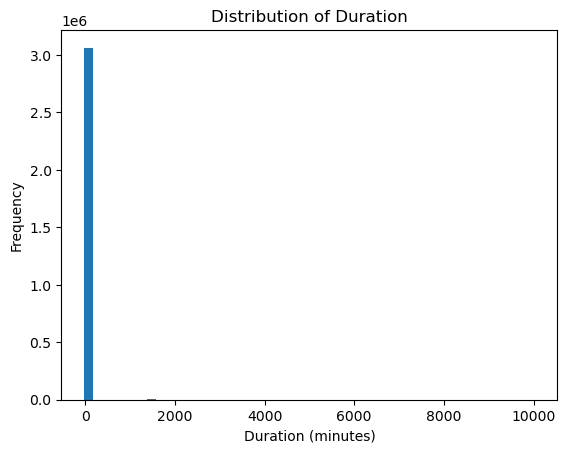

Fraction of records remaining after removing outliers: 0.9812


In [7]:

# Step 1: Explore the distribution
plt.hist(df_jan['duration'], bins=50)
plt.title('Distribution of Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

# Step 2: Remove outliers (keep duration between 1 and 60 inclusive)
initial_count = len(df_jan)
filtered_df_jan = df_jan[(df_jan['duration'] >= 1) & (df_jan['duration'] <= 60)]
final_count = len(filtered_df_jan)

# Step 3: Calculate fraction of records left
fraction_remaining = final_count / initial_count
print(f"Fraction of records remaining after removing outliers: {fraction_remaining:.4f}")


In [18]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer


# Step 1: Convert IDs to strings (so DictVectorizer one-hot encodes instead of label encoding)
filtered_df_jan['PULocationID'] = filtered_df_jan['PULocationID'].astype(str)
filtered_df_jan['DOLocationID'] =filtered_df_jan['DOLocationID'].astype(str)

# Step 2: Convert to list of dictionaries
dicts = filtered_df_jan[['PULocationID','DOLocationID']].to_dict(orient='records')

# Step 3: Fit the DictVectorizer
dv_og = DictVectorizer()
X = dv_og.fit_transform(dicts)

# Step 4: Get dimensionality (number of columns/features)
print(f"Shape of feature matrix: {X.shape}")
print(f"Number of features (columns): {X.shape[1]}")


/var/folders/qt/04g41gpn5px380691hrmt0bm0000gn/T/ipykernel_21866/137451312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_jan['PULocationID'] = filtered_df_jan['PULocationID'].astype(str)
/var/folders/qt/04g41gpn5px380691hrmt0bm0000gn/T/ipykernel_21866/137451312.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_jan['DOLocationID'] =filtered_df_jan['DOLocationID'].astype(str)


Shape of feature matrix: (3009173, 515)
Number of features (columns): 515


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
y_train = filtered_df_jan['duration'].values  # response variable

# Step 2: Use X from DictVectorizer step (sparse one-hot encoded matrix)
# Already defined earlier: X = dv.fit_transform(dicts)

# Step 3: Train the Linear Regression model
model = LinearRegression()
model.fit(X, y_train)

# Step 4: Predict on training set
y_pred = model.predict(X)

# Step 5: Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"RMSE on training data: {rmse:.2f}")

RMSE on training data: 7.65


In [19]:
df_feb['PULocationID'] = df_feb['PULocationID'].astype(str)
df_feb['DOLocationID'] =df_feb['DOLocationID'].astype(str)

# Step 2: Turn into list of dictionaries
val_dicts = df_feb[['PULocationID', 'DOLocationID']].to_dict(orient='records')

# Step 3: Transform using the fitted DictVectorizer
X_val = dv_og.transform(val_dicts)  # NOTE: don't fit again, just transform

# Step 4: Define target variable for validation set
y_val = df_feb['duration'].values

# Step 5: Predict using the trained model
y_pred_val = model.predict(X_val)

# Step 6: Calculate RMSE
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"RMSE on validation data: {rmse_val:.2f}")

RMSE on validation data: 42.28


## Feb 23 data to be used for testing
To avoid memory issue-combining both features

In [10]:
df_train=filtered_df_jan.copy()

In [11]:
from sklearn.metrics import root_mean_squared_error

In [12]:
df_train['PU_DO'] = df_train['PULocationID'].astype(str) + '_' + df_train['DOLocationID'].astype(str)
df_feb['PU_DO'] = df_feb['PULocationID'].astype(str) + '_' + df_feb['DOLocationID'].astype(str)

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_feb[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_feb[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

41.77303657393267

ValueError: X has 21801 features, but LinearRegression is expecting 515 features as input.

In [ ]:
%pip install pyarrow
%pip install fastparquet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 66.4 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
